<a href="https://colab.research.google.com/github/m-garciar/machine-learning/blob/main/Taller_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Importación de librerias

Este modelo se realizo con el 25% de los datos

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 4.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import random
import urllib.request

import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.cbook as cbook
%matplotlib inline

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow import keras
from pathlib import Path
import glob
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential

from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from tqdm import tqdm
from io import StringIO

import keras_tuner as kt

from PIL import Image
import requests
import scipy.misc
import base64
import PIL.Image


from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#1. Entendimiento del negocio
El objetivo es poder clasificar los poster de las películar por género. Debido a que una misma película puede pertenecer a varios géneros, se realizará una clasificación multietiqueta.

#2. Entendimiento de los datos
Se realiza la carga de los posters renombrados con el Id asiganado en la base de datos. No todas las URL llevaban a un poster.

Una vez cargadas se depositan en el directorio de imágenes.

Se realiza la división aleatoria de los datos dejando el 80% para la fase de entrenamiento y el 20% para la fase de evaluación. La partición se hizo fuera de colab debido a reinicio constante por falta de RAM.

In [ ]:
!unzip /Test.zip

Archive:  /Test.zip
  inflating: Test/10057.jpg          
  inflating: Test/10071.jpg          
 extracting: Test/10155.jpg          
 extracting: Test/10195.jpg          
  inflating: Test/10208.jpg          
 extracting: Test/10247.jpg          
 extracting: Test/10267.jpg          
 extracting: Test/10281.jpg          
 extracting: Test/10307.jpg          
 extracting: Test/10323.jpg          
  inflating: Test/10418.jpg          
  inflating: Test/10726.jpg          
 extracting: Test/10747.jpg          
  inflating: Test/10806.jpg          
 extracting: Test/10821.jpg          
  inflating: Test/11000.jpg          
  inflating: Test/1105.jpg           
  inflating: Test/11071.jpg          
 extracting: Test/11130.jpg          
  inflating: Test/11157.jpg          
  inflating: Test/11193.jpg          
  inflating: Test/11237.jpg          
  inflating: Test/11293.jpg          
 extracting: Test/11358.jpg          
  inflating: Test/11362.jpg          
 extracting: Test/11370.jpg   

In [ ]:
!unzip Train.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Train/52733.jpg         
 extracting: Train/52738.jpg         
 extracting: Train/52749.jpg         
 extracting: Train/52765.jpg         
  inflating: Train/52781.jpg         
  inflating: Train/52786.jpg         
  inflating: Train/52792.jpg         
 extracting: Train/52793.jpg         
  inflating: Train/52805.jpg         
  inflating: Train/52809.jpg         
  inflating: Train/52811.jpg         
 extracting: Train/52812.jpg         
  inflating: Train/52832.jpg         
  inflating: Train/52837.jpg         
  inflating: Train/52844.jpg         
  inflating: Train/52846.jpg         
  inflating: Train/52847.jpg         
  inflating: Train/52861.jpg         
 extracting: Train/52876.jpg         
  inflating: Train/52877.jpg         
 extracting: Train/52880.jpg         
 extracting: Train/52888.jpg         
  inflating: Train/52893.jpg         
  inflating: Train/52896.jpg         
  inflating: Train/52902.jp

In [ ]:
image_directory = '/content/Train'
# de entrenamiento

In [ ]:
image_directory2 = '/content/Test'
# de validación

Las categorías adultos, biografía, programa de juego o reality-show y talk-show estan muy poco representadas (la mayoría con menos de 10 poster, razón por la cual dificilmente se podrá entrenar un algoritmo para detectarlas y se decide excluirlas previa a la carga de datos. Asimismo se crea un One-hot de los demás géneros y se eliminan la variable original. 
Se carga únicamente el Id y el one-hot de los géneros.

In [ ]:
df = pd.read_csv('train.csv')    
print(df.head())    
print(df.columns)

      Id  Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  \
0  23158       0          0          0       1      0            0      0   
1  69064       0          0          0       0      0            0      0   
2  54218       0          0          0       0      1            0      1   
3  34182       0          1          0       0      0            0      1   
4  75885       0          1          0       0      0            0      1   

   Family  Fantasy  ...  Music  Musical  Mystery  Romance  Sci-Fi  Short  \
0       0        0  ...      0        1        0        1       0      0   
1       0        0  ...      0        0        1        0       0      0   
2       0        0  ...      0        0        0        0       0      0   
3       0        0  ...      0        0        0        1       0      0   
4       0        0  ...      0        0        0        0       0      0   

   Sport  Thriller  War  Western  
0      0         0    0        0  
1      0  

In [ ]:
df2 = pd.read_csv('/test.csv')    
print(df2.head())    
print(df2.columns)

   Id  Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  \
0   3       0          0          1       1      0            0      0   
1   5       0          0          0       0      0            0      0   
2   8       0          0          0       0      0            1      0   
3  12       0          0          0       0      0            1      0   
4  14       0          0          0       1      0            0      0   

   Family  Fantasy  ...  Music  Musical  Mystery  Romance  Sci-Fi  Short  \
0       0        0  ...      0        0        0        0       0      1   
1       0        0  ...      0        0        0        0       0      1   
2       0        0  ...      0        0        0        0       0      1   
3       0        0  ...      0        0        0        0       0      1   
4       0        0  ...      0        0        0        0       0      1   

   Sport  Thriller  War  Western  
0      0         0    0        0  
1      0         0    0     

#3. Preparación de los datos
Se eliminan las variables duplicadas

In [ ]:
df = df.drop_duplicates (subset='Id',keep ='first')
df
#dataframe de entrenamiento

,Id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,23158,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,69064,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,54218,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34182,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,75885,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7115,28407,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
7116,80489,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7117,68983,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7118,76827,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df2 = df2.drop_duplicates (subset='Id',keep ='first')
df2
#dataframe de evaluación

,Id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,3,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,8,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,12,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,14,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1774,35170,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1775,35189,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1776,35195,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1777,35209,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Se cargan las imágenes de entrenamiento por Id en un arreglo, eliminando los Id que no tienen un poster asociado. 

In [ ]:
linksout = []
for i in tqdm(range(df.shape[0])):
  try:
    
    image = tf.keras.preprocessing.image.load_img(image_directory+'/' +str(df['Id'][i])+'.jpg')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    if i==3: X_dataset = input_arr 
    else:X_dataset = np.r_[X_dataset,input_arr]

  except: 
    linksout.append(i)

100%|██████████| 7120/7120 [42:39<00:00,  2.78it/s]


In [ ]:
X_train= np.array(X_dataset)

In [ ]:
linksout2 = []
for i in tqdm(range(df2.shape[0])):
  try:
    
    image2 = tf.keras.preprocessing.image.load_img(image_directory2+'/' +str(df2['Id'][i])+'.jpg')
    input_arr = tf.keras.preprocessing.image.img_to_array(image2)
    if i==3: X_dataset2 = input_arr 
    else:X_dataset2 = np.r_[X_dataset2,input_arr]

  except: 
    linksout2.append(i)

100%|██████████| 1779/1779 [03:54<00:00,  7.58it/s]


Se elimina el ID dejando únicamente los géneros como variables de desenlace

In [ ]:
y_train = np.array(df.drop(['Id'], axis=1))

In [ ]:
y_test = np.array(df2.drop(['Id'], axis=1))

Se ajusta la forma del arreglo para que sea compatible con la de y

In [ ]:
X_train = np.split(X_dataset,7117,axis=0)
X_train=np.array(X_train)
X_train.shape

(7117, 268, 182, 3)

In [ ]:
X_test = np.split(X_dataset2,1776,axis=0)
X_test=np.array(X_test)
X_test.shape

(1776, 268, 182, 3)

Se restan 3 porque se corre el marco de lectura respecto a las imágenes.

In [ ]:
y_train=y_train[:-3]

In [ ]:
y_test=y_test[:-3]

Evaluando la congruencia del marco del lectura

In [ ]:
df.where(df2['Id'] == 3)

,Id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#4. Modelamiento

Se define el tamaño del batch y el tipo de modelo de la red, el activador de la capa de salida es la función sigmoide para lograr la clasificación multietiqueta.

Debido a que todas las imágenes tienen las mismas dimensiones se deja la altura 268 y en ancho en 182.
Como se vio previamente, el desempeño con perceptron multicapa es deficiente por lo cual se cambia el modelo por una red que incluye capas convolucionales.

In [ ]:


model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(268,182,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 16)      1216      
                                                                 
 batch_normalization (BatchN  (None, 196, 196, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 98, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0

Se elije entropia cruzada binaria como funcion de pérdida debido a que para cada tipo de género la decisión es binaria (pertenece/no pertenece)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=25)

#Evaluación

## Gráfico de desempeño de iteraciones del modelo en las épocas vs. función de pérdida en entrenamiento y validación

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Gráfico de desempeño de iteraciones del modelo en las épocas vs. precisión en entrenamiento y validación

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Clasificación de un poster

Se carga una de las imágenes que se no fueron incluidas en esta muestra reducida

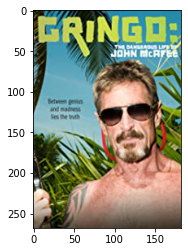

In [ ]:
prueba = tf.keras.preprocessing.image.load_img('/6071534.jpg')
input_arr = tf.keras.preprocessing.image.img_to_array(prueba)
plt.imshow(prueba)

In [ ]:
clases = np.array(df.columns[2:])
probabilidad = model.predict(prueba) 
generos = np.argsort(probabilidad[0])[:-11:-1]

for i in range(10):
    print("{}".format(clases[generos[i]])+" ({:.3})".format(probabilidad[0][generos[i]]))